# Generating Names with a Character-Level RNN 

#### http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

## Perparing the Data

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): 
    return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("O'Néàl")
print(unicodeToAscii("O'Néàl"))

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/RNN_names/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

O'Néàl
O'Neal
# categories: 18 ['Korean', 'Chinese', 'Japanese', 'Polish', 'Portuguese', 'Greek', 'English', 'Italian', 'German', 'Czech', 'Dutch', 'Arabic', 'Vietnamese', 'Scottish', 'Irish', 'French', 'Spanish', 'Russian']


## Creating the Network 

#### model is used to predict the next letter from the current letter for each timestep

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Training

## Preparing for Training 

In [5]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [7]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [8]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

## Training the Network 

In [21]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 18s (5000 5%) 3.2428
0m 34s (10000 10%) 1.6945
0m 50s (15000 15%) 3.0963
1m 4s (20000 20%) 2.1802
1m 20s (25000 25%) 2.7398
1m 35s (30000 30%) 2.7811
1m 51s (35000 35%) 2.4164
2m 6s (40000 40%) 2.3240
2m 21s (45000 45%) 2.4394
2m 36s (50000 50%) 2.0421
2m 50s (55000 55%) 2.6606
3m 5s (60000 60%) 2.0655
3m 21s (65000 65%) 2.2094
3m 37s (70000 70%) 2.3196
3m 53s (75000 75%) 2.8624
4m 8s (80000 80%) 2.2733
4m 24s (85000 85%) 2.0786
4m 39s (90000 90%) 2.4286
4m 54s (95000 95%) 2.6825
5m 9s (100000 100%) 2.7149


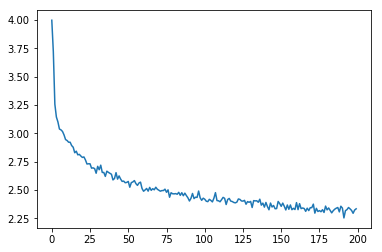

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.figure()
plt.plot(all_losses)

## Sampling the Network 

In [32]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

print(sample('Chinese', 'Q'))
        
samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

Quin
Rovaki
Uakin
Shavakovov
Geren
Eren
Roure
Sara
Pare
Aller
Cha
Han
Iin
